la dinamica della rete è descitta dall'equazione: tau*dx_i/dt=-x_i(t)+sum(J_ij*r_j(t))+sum(B_ik*u_k(t)) con r_j(t)=tanh(x_i(t))

In [1]:
import numpy as np
import random 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

Generation class trial

In [2]:
def trial(stim1,stim2,T=1000):
        
    u=np.zeros((T,2))
    
    ty=2*stim1+stim2          #!!!! modified              #trial type: 0=AA, 1=BA, 2=AB, 3=BB

    ''' 
    if stim=0 (A) u1=1 and u2=0
    if stim=1 (B) u1=0 and u2=1
    '''
    
    u[:200,stim1]=1
    u[400:600,stim2]=1

    ''' 
    if identical inputs, output = -1
    if different inputs, output = 1
    '''
    
    #y[800:1000]=-1+2*np.mod(stim1+stim2,2)
    y=-1+2*np.mod(stim1+stim2,2)
    
    return u,y,ty


def generate_trials(n_trials,T=1000):

    U = np.zeros((n_trials,T,2))
    Y = np.zeros(n_trials)#,T))
    TY=np.zeros(n_trials)

    for n in range(n_trials):
        
        u,y,ty=trial(T)
        
        U[n,:,:]=u
        #Y[n,:]=y
        Y[n]=y
        TY[n]=ty

    return U,Y,TY
        

Constants and initialization

In [3]:
##### eta=0.1, alpha=0.5, rate=1., th=0.001


N=200           #numero neuroni
M=2             #numero input
tau=30          #tempo di rilassamento
g=1.5           #early chaotic
eta=0.1         #learning rate
alpha=0.5       #!!!! running average of response
beta = 0.05     #!!!! running average of x
rate=1./1000    #!!!
th=1E-3

dt=1.
T=1000
n_trials=4
tottime=T*n_trials

b=dt/tau            #per semplicità definisco una nuova costante


J=np.zeros((N,N))
deltaJ=np.zeros((N,N))  
x=np.zeros(N)       ##!!!
x_ave=np.zeros(N)   ##!!!
r=np.zeros(N)
u=np.zeros((M,tottime))

E=np.zeros((N,N))#,tottime)) 

z=np.zeros(tottime)
B=np.zeros((N,M))

R_ave=np.zeros(4)       #running average for each trial type
err=np.zeros(n_trials)



PRE TRAINING

In [4]:
J = np.random.normal(0,g/np.sqrt(N),(N,N))

B= -1+2*np.random.rand(N,M)

J = np.loadtxt('Jstep0.txt')
B = np.loadtxt('B_input.txt')

Fix biased neurons

In [5]:
n_fixed=4

x[0:4]=1



NO Training (NO UPDATE)

In [6]:
np.random.seed(0)

x[:]=-0.1+0.2*np.random.rand(N) #!!!!
x[0:3]=1
E=np.zeros((N,N))#,tottime)) 
r[:]=0
R_ave=np.zeros(4)
outp=0
deltaE=np.zeros((N,N))
deltax=np.zeros(N)
rprev=np.zeros(N)

tottime=4000
XX=np.zeros((200,tottime))
U0=np.zeros(tottime)
U1=np.zeros(tottime)


for ntime in range(tottime):

    XX[:,ntime]=x[:]

    
    if(np.mod(ntime,1*T)==0):
        print(ntime)
        print(R_ave)

    trialtime=np.mod(ntime,T)
    
    curr_trial = np.floor(ntime/T).astype(int)
    
    if trialtime==0: 
        stim2=np.mod(curr_trial,2).astype(int)
        stim1=(np.mod(curr_trial,4)/2).astype(int)
        u,y,ty=trial(stim1, stim2)

    U0[ntime]=u[trialtime,0]
    U1[ntime]=u[trialtime,1]
    
    if trialtime>=800 and trialtime<1000:
        outp+=r[-1] 
                
    r=np.tanh(x)
    
    noise1=(np.random.rand(N)<rate)*(-0.5+1.*np.random.rand(N))
            
    sumJ=np.matmul(J,r)
            
    sumB=np.matmul(B,u[trialtime,:])
        
    x[4:]=x[4:]/(1+b)+b/(1+b)*(sumJ[4:]+sumB[4:])       #IMPLICITO

    x+=noise1 

    deltax=x-x_ave
    
    x_ave=beta*x_ave+(1.-beta)*x;  
   
    rprev=r
    #deltaE=np.outer(deltax,rprev) 
    #deltaE=pow(deltaE,3)
    
    #E+=deltaE

    
    if(np.mod(ntime,T)==T-1):                       #ultimo time step di ciascun trial 
        
        curr_trial=ntime//T
        curr_ty=ty #trial type : 0=AA, 1=BA, 2=AB, 3=BB
        outp=outp/200

        err[curr_trial]=abs(y-outp)           
        R=-err[curr_trial]
        
        print('type',curr_ty,err[curr_trial])
    
        #deltaJ=-eta*(R-R_ave[curr_ty])*E*(-R_ave[curr_ty]);

        ### !!!
        th=1.E-3
        deltaJ[deltaJ>th]=th
        deltaJ[deltaJ<-th]=-th

        #J+=deltaJ

        R_ave[curr_ty]=alpha*R_ave[curr_ty]+(1-alpha)*R
        
        deltaJ=np.zeros((N,N)) 
        E=np.zeros((N,N))
        x[:]=-0.1+0.2*np.random.rand(N)
        x[:4]=1
        r[:]=0
        outp=0

        

0
[0. 0. 0. 0.]
type 0 1.3690249071545249
1000
[-0.68451245  0.          0.          0.        ]
type 1 0.46135657513606665
2000
[-0.68451245 -0.23067829  0.          0.        ]
type 2 0.13295467140409
3000
[-0.68451245 -0.23067829 -0.06647734  0.        ]
type 3 1.845320489838731


In [9]:
XX_AA=np.zeros((200,1000))
XX_AB=np.zeros((200,1000))
XX_BA=np.zeros((200,1000))
XX_BB=np.zeros((200,1000))

for i in range(10):
    for ntime in range(1000):
        XX_AA[:,ntime]+=XX[:,ntime+4*i*1000]
        XX_AB[:,ntime]+=XX[:,1000+ntime+4*i*1000]
        XX_BA[:,ntime]+=XX[:,2000+ntime+4*i*1000]
        XX_BB[:,ntime]+=XX[:,3000+ntime+4*i*1000]

XX_AA/=10
XX_AB/=10
XX_BA/=10
XX_BB/=10


plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(11,9))
plt.title('Tipo trial AA, pre-training', fontsize = 25, pad=25)
plt.xlabel('tempo (ms)')
plt.ylabel('neuroni')
plt.tick_params(top=True, bottom=True, left=True, right=False,
                labelleft=True, labelbottom=True)
plt.matshow(XX_AA,cmap='bwr',fignum=0,aspect='auto')
plt.colorbar()

plt.savefig('activity_pre_AA.png')

IndexError: index 4000 is out of bounds for axis 1 with size 4000

In [ ]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(11,9))
plt.title('Tipo trial AB, pre-training', fontsize = 25, pad=25)
plt.xlabel('tempo (ms)')
plt.ylabel('neuroni')
plt.tick_params(top=True, bottom=True, left=True, right=False,
                labelleft=True, labelbottom=True)
plt.matshow(XX_AB,cmap='bwr',fignum=0,aspect='auto')
plt.colorbar()

plt.savefig('activity_pre_AB.png')

In [ ]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(11,9))
plt.title('Tipo trial BA, pre-training', fontsize = 25, pad=25)
plt.xlabel('tempo (ms)')
plt.ylabel('neuroni')
plt.tick_params(top=True, bottom=True, left=True, right=False,
                labelleft=True, labelbottom=True)
plt.matshow(XX_BA,cmap='bwr',fignum=0,aspect='auto')
plt.colorbar()

plt.savefig('activity_pre_BA.png')

In [ ]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(11,9))
plt.title('Tipo trial BB, pre-training', fontsize = 25, pad=25)
plt.xlabel('tempo (ms)')
plt.ylabel('neuroni')
plt.tick_params(top=True, bottom=True, left=True, right=False,
                labelleft=True, labelbottom=True)
plt.matshow(XX_BB,cmap='bwr',fignum=0,aspect='auto')
plt.colorbar()

plt.savefig('activity_pre_BB.png')

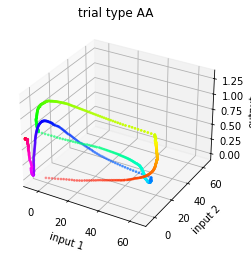

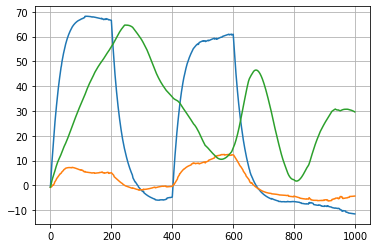

In [ ]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection ="3d")


ax.scatter3D(np.matmul(B[:,0],XX[:,:1000]),np.matmul(B[:,1],XX[:,:1000]),XX[-1,:1000],s=3,c=np.arange(1000),cmap='hsv')
ax.set_xlim(-10,70)
ax.set_ylim(-10,70)
ax.set_xlabel('input 1')
ax.set_ylabel('input 2')
ax.set_zlabel('output')
ax.set_title('trial type AA')


plt.figure()
plt.plot(np.matmul(B[:,0],XX[:,:1000]))
plt.plot(np.matmul(B[:,1],XX[:,:1000]))
plt.plot(XX[-1,:1000]*50)
plt.grid()


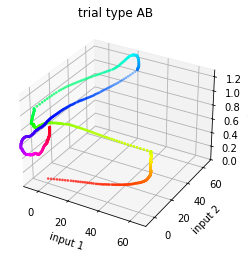

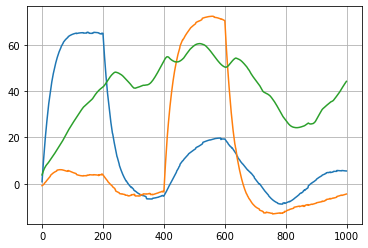

In [ ]:
ax = plt.axes(projection ="3d")


ax.scatter3D(np.matmul(B[:,0],XX[:,1000:2000]),np.matmul(B[:,1],XX[:,1000:2000]),XX[-1,1000:2000],s=3,c=np.arange(1000),cmap='hsv')
ax.set_xlim(-10,70)
ax.set_ylim(-10,70)
ax.set_xlabel('input 1')
ax.set_ylabel('input 2')
ax.set_zlabel('output')
ax.set_title('trial type AB')


plt.figure()
plt.plot(np.matmul(B[:,0],XX[:,1000:2000]))
plt.plot(np.matmul(B[:,1],XX[:,1000:2000]))
plt.plot(XX[-1,1000:2000]*50)
plt.grid()


POST TRAINING

In [ ]:
J = np.random.normal(0,g/np.sqrt(N),(N,N))

B= -1+2*np.random.rand(N,M)

J = np.loadtxt('Jstep20.txt')
B = np.loadtxt('B_input.txt')

Fix biased neurons

In [ ]:
n_fixed=4

x[0:4]=1



In [ ]:
np.random.seed(0)

x[:]=-0.1+0.2*np.random.rand(N) #!!!!
x[0:3]=1
E=np.zeros((N,N))#,tottime)) 
r[:]=0
R_ave=np.zeros(4)
outp=0
deltaE=np.zeros((N,N))
deltax=np.zeros(N)
rprev=np.zeros(N)

tottime=4000
XX_f=np.zeros((200,tottime))


for ntime in range(tottime):

    XX_f[:,ntime]=x[:]

    
    if(np.mod(ntime,1*T)==0):
        print(ntime)
        print(R_ave)

    trialtime=np.mod(ntime,T)
    
    curr_trial = np.floor(ntime/T).astype(int)
    
    if trialtime==0: 
        stim2=np.mod(curr_trial,2).astype(int)
        stim1=(np.mod(curr_trial,4)/2).astype(int)
        u,y,ty=trial(stim1, stim2)
    
    UU[ntime,:]=u[trialtime,:]

    
    if trialtime>=800 and trialtime<1000:
        outp+=r[-1] 
                
    r=np.tanh(x)
    
    noise1=(np.random.rand(N)<rate)*(-0.5+1.*np.random.rand(N))
            
    sumJ=np.matmul(J,r)
            
    sumB=np.matmul(B,u[trialtime,:])
        
    x[4:]=x[4:]/(1+b)+b/(1+b)*(sumJ[4:]+sumB[4:])       #IMPLICITO

    x+=noise1 

    deltax=x-x_ave
    
    x_ave=beta*x_ave+(1.-beta)*x;  
   
    rprev=r
    deltaE=np.outer(deltax,rprev) 
    deltaE=pow(deltaE,3)
    
    E+=deltaE

    
    if(np.mod(ntime,T)==T-1):                       #ultimo time step di ciascun trial 
        
        curr_trial=ntime//T
        curr_ty=ty #trial type : 0=AA, 1=BA, 2=AB, 3=BB
        outp=outp/200

        err[curr_trial]=abs(y-outp)           
        R=-err[curr_trial]
        
        print('type',curr_ty,err[curr_trial])
    
        deltaJ=-eta*(R-R_ave[curr_ty])*E*(-R_ave[curr_ty]);

        ### !!!
        th=1.E-3
        deltaJ[deltaJ>th]=th
        deltaJ[deltaJ<-th]=-th

        #J+=deltaJ

        R_ave[curr_ty]=alpha*R_ave[curr_ty]+(1-alpha)*R
        
        deltaJ=np.zeros((N,N)) 
        E=np.zeros((N,N))
        x[:]=-0.1+0.2*np.random.rand(N)
        x[:4]=1
        r[:]=0
        outp=0

        

0
[0. 0. 0. 0.]
type 0 0.1820909499790414
1000
[-0.09104547  0.          0.          0.        ]
type 1 0.05315156048387859
2000
[-0.09104547 -0.02657578  0.          0.        ]
type 2 0.09428598234128938
3000
[-0.09104547 -0.02657578 -0.04714299  0.        ]
type 3 0.04716046433521304


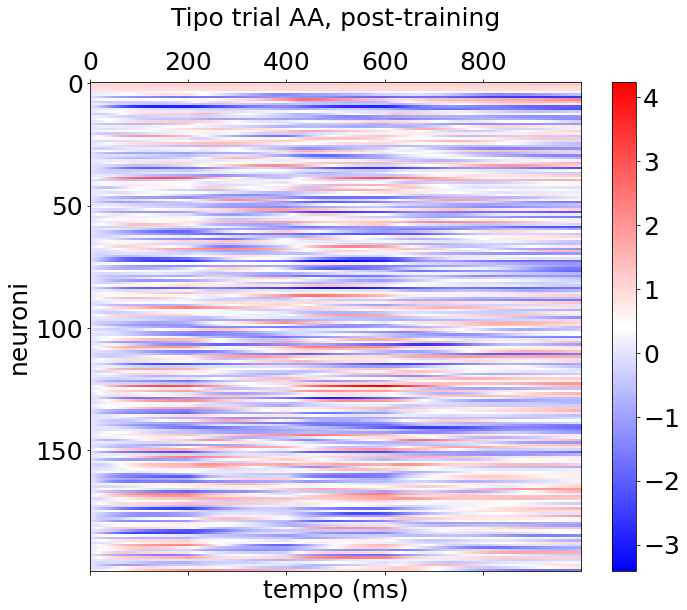

In [ ]:
XX_AA_f=np.zeros((200,1000))
XX_AB_f=np.zeros((200,1000))
XX_BA_f=np.zeros((200,1000))
XX_BB_f=np.zeros((200,1000))

for i in range(10):
    for ntime in range(1000):
        XX_AA_f[:,ntime]+=XX_f[:,ntime+4*i*1000]
        XX_AB_f[:,ntime]+=XX_f[:,1000+ntime+4*i*1000]
        XX_BA_f[:,ntime]+=XX_f[:,2000+ntime+4*i*1000]
        XX_BB_f[:,ntime]+=XX_f[:,3000+ntime+4*i*1000]

XX_AA_f/=10
XX_AB_f/=10
XX_BA_f/=10
XX_BB_f/=10


plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(11,9))
plt.title('Tipo trial AA, post-training', fontsize = 25, pad=25)
plt.xlabel('tempo (ms)')
plt.ylabel('neuroni')
plt.tick_params(top=True, bottom=True, left=True, right=False,
                labelleft=True, labelbottom=True)
plt.matshow(XX_AA_f,cmap='bwr',fignum=0,aspect='auto')
plt.colorbar()

plt.savefig('activity_post_AA.png')

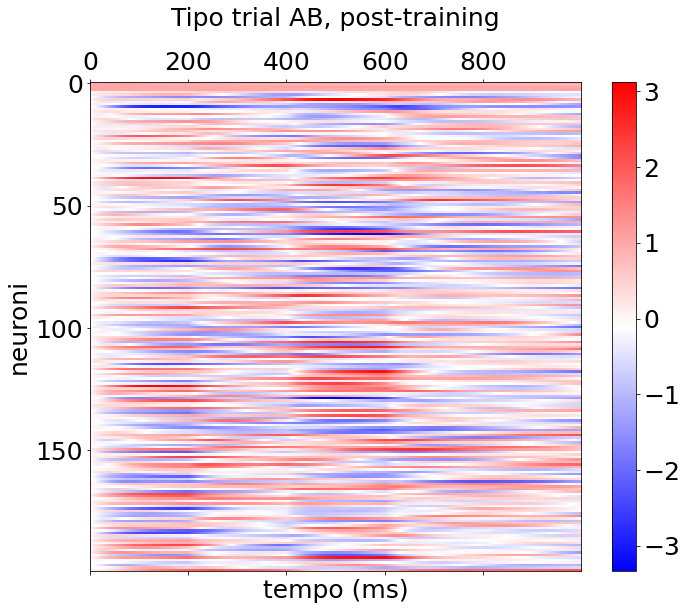

In [ ]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(11,9))
plt.title('Tipo trial AB, post-training', fontsize = 25, pad=25)
plt.xlabel('tempo (ms)')
plt.ylabel('neuroni')
plt.tick_params(top=True, bottom=True, left=True, right=False,
                labelleft=True, labelbottom=True)
plt.matshow(XX_AB_f,cmap='bwr',fignum=0,aspect='auto')
plt.colorbar()

plt.savefig('activity_post_AB.png')

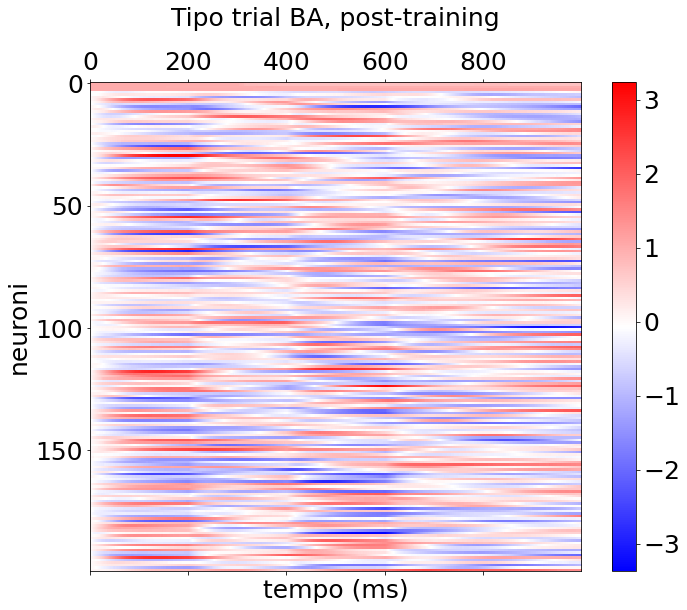

In [ ]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(11,9))
plt.title('Tipo trial BA, post-training', fontsize = 25, pad=25)
plt.xlabel('tempo (ms)')
plt.ylabel('neuroni')
plt.tick_params(top=True, bottom=True, left=True, right=False,
                labelleft=True, labelbottom=True)
plt.matshow(XX_BA_f,cmap='bwr',fignum=0,aspect='auto')
plt.colorbar()

plt.savefig('activity_post_BA.png')

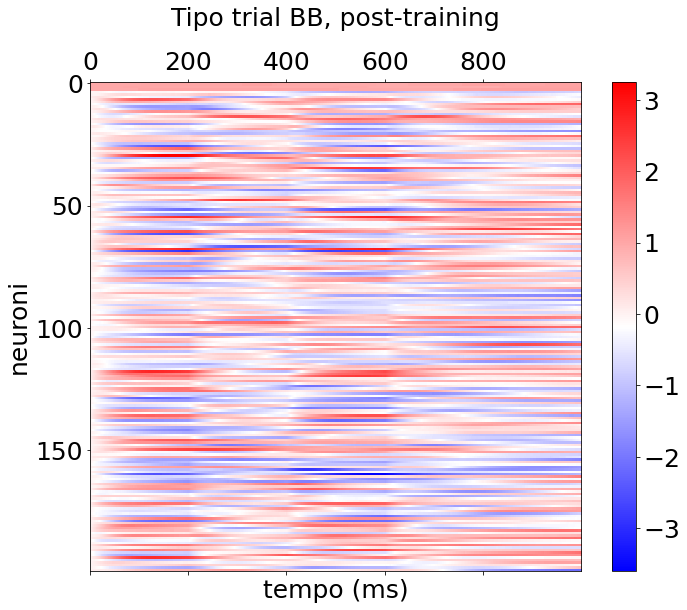

In [ ]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(11,9))
plt.title('Tipo trial BB, post-training', fontsize = 25, pad=25)
plt.xlabel('tempo (ms)')
plt.ylabel('neuroni')
plt.tick_params(top=True, bottom=True, left=True, right=False,
                labelleft=True, labelbottom=True)
plt.matshow(XX_BB_f,cmap='bwr',fignum=0,aspect='auto')
plt.colorbar()

plt.savefig('activity_post_BB.png')

DIFFERENCES

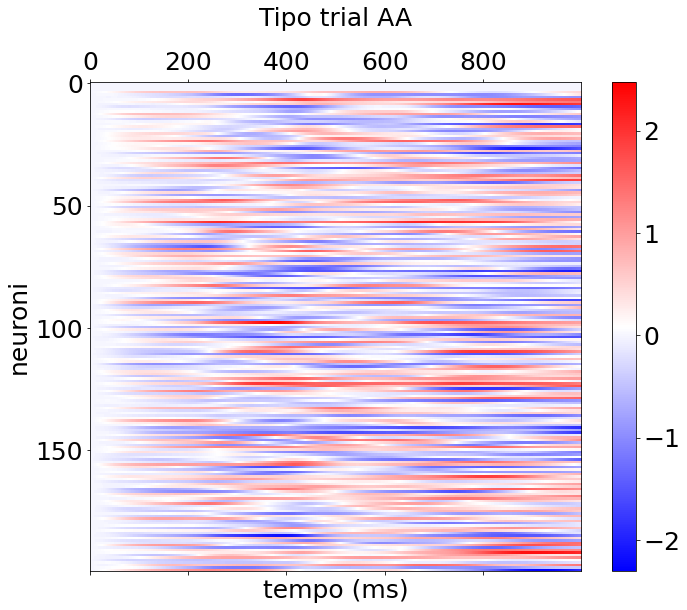

In [ ]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(11,9))
plt.title('Tipo trial AA', fontsize = 25, pad=25)
plt.xlabel('tempo (ms)')
plt.ylabel('neuroni')
plt.tick_params(top=True, bottom=True, left=True, right=False,
                labelleft=True, labelbottom=True)
plt.matshow(XX_AA_f-XX_AA,cmap='bwr',fignum=0,aspect='auto')
plt.colorbar()

plt.savefig('activity_diff_AA.png')

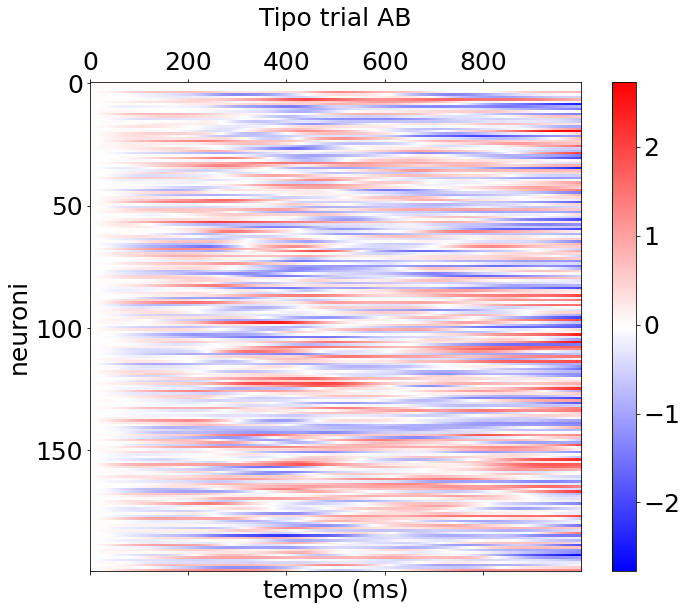

In [ ]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(11,9))
plt.title('Tipo trial AB', fontsize = 25, pad=25)
plt.xlabel('tempo (ms)')
plt.ylabel('neuroni')
plt.tick_params(top=True, bottom=True, left=True, right=False,
                labelleft=True, labelbottom=True)
plt.matshow(XX_AB_f-XX_AB,cmap='bwr',fignum=0,aspect='auto')
plt.colorbar()

plt.savefig('activity_diff_AB.png')

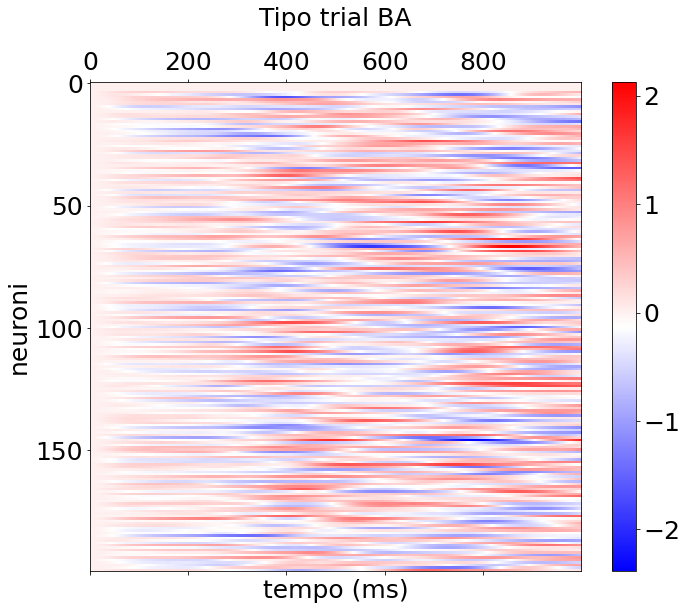

In [ ]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(11,9))
plt.title('Tipo trial BA', fontsize = 25, pad=25)
plt.xlabel('tempo (ms)')
plt.ylabel('neuroni')
plt.tick_params(top=True, bottom=True, left=True, right=False,
                labelleft=True, labelbottom=True)
plt.matshow(XX_BA_f-XX_BA,cmap='bwr',fignum=0,aspect='auto')
plt.colorbar()

plt.savefig('activity_diff_BA.png')

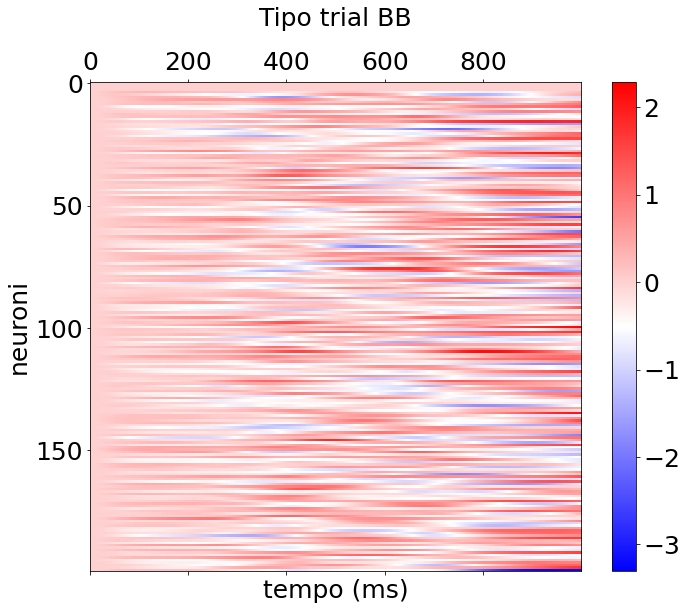

In [ ]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(11,9))
plt.title('Tipo trial BB', fontsize = 25, pad=25)
plt.xlabel('tempo (ms)')
plt.ylabel('neuroni')
plt.tick_params(top=True, bottom=True, left=True, right=False,
                labelleft=True, labelbottom=True)
plt.matshow(XX_BB_f-XX_BB,cmap='bwr',fignum=0,aspect='auto')
plt.colorbar()

plt.savefig('activity_diff_BB.png')

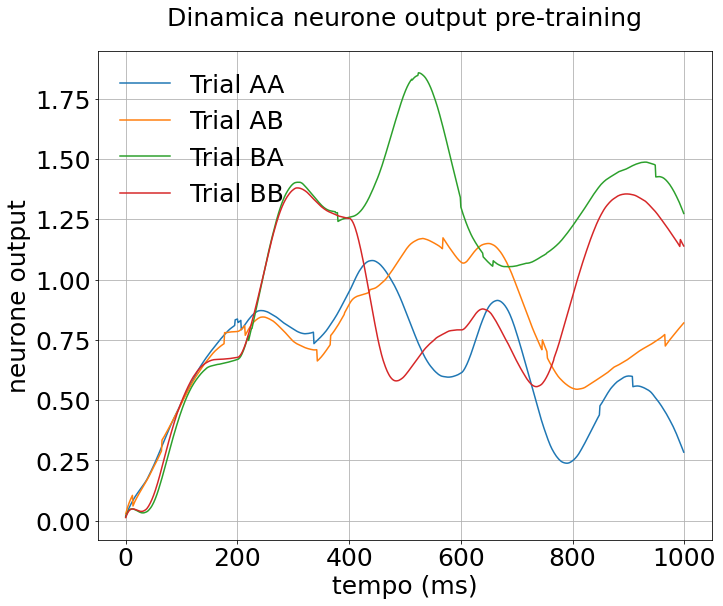

In [ ]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(11,9))
plt.title('Dinamica neurone output pre-training', fontsize = 25, pad=25)
plt.xlabel('tempo (ms)')
plt.ylabel('neurone output')

RR_AA=np.tanh(XX_AA)
RR_AA_f=np.tanh(XX_AA_f)
RR_AB=np.tanh(XX_AB)
RR_AB_f=np.tanh(XX_AB_f)
RR_BA=np.tanh(XX_BA)
RR_BA_f=np.tanh(XX_BA_f)
RR_BB=np.tanh(XX_BB)
RR_BB_f=np.tanh(XX_BB_f)


plt.plot(XX_AA[199,:], label='Trial AA')
plt.plot(XX_AB[199,:], label='Trial AB')
plt.plot(XX_BA[199,:], label='Trial BA')
plt.plot(XX_BB[199,:], label='Trial BB')

plt.legend(loc=2, frameon=False)
plt.grid()
plt.savefig('dyn_output_pre.png')

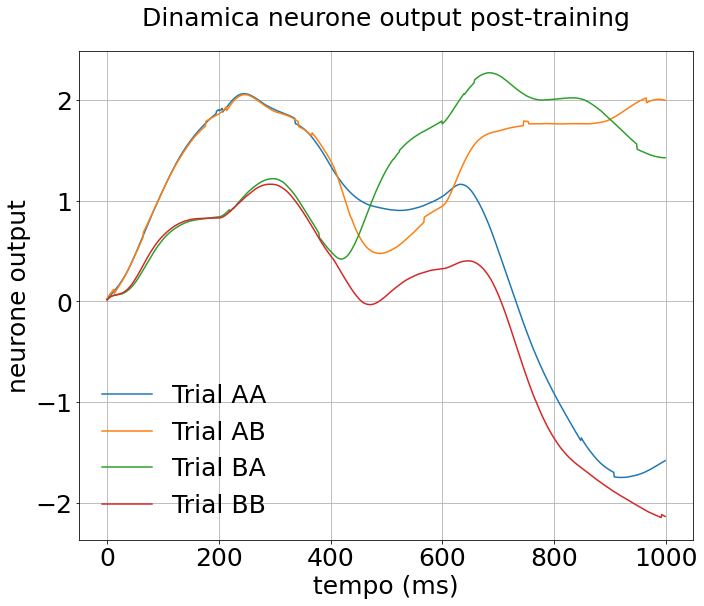

In [ ]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(11,9))
plt.title('Dinamica neurone output post-training', fontsize = 25, pad=25)
plt.xlabel('tempo (ms)')
plt.ylabel('neurone output')

plt.plot(XX_AA_f[199,:], label='Trial AA')
plt.plot(XX_AB_f[199,:], label='Trial AB')
plt.plot(XX_BA_f[199,:], label='Trial BA')
plt.plot(XX_BB_f[199,:], label='Trial BB')

plt.legend(loc=3, frameon=False)
plt.grid()

plt.savefig('dyn_output_post.png')

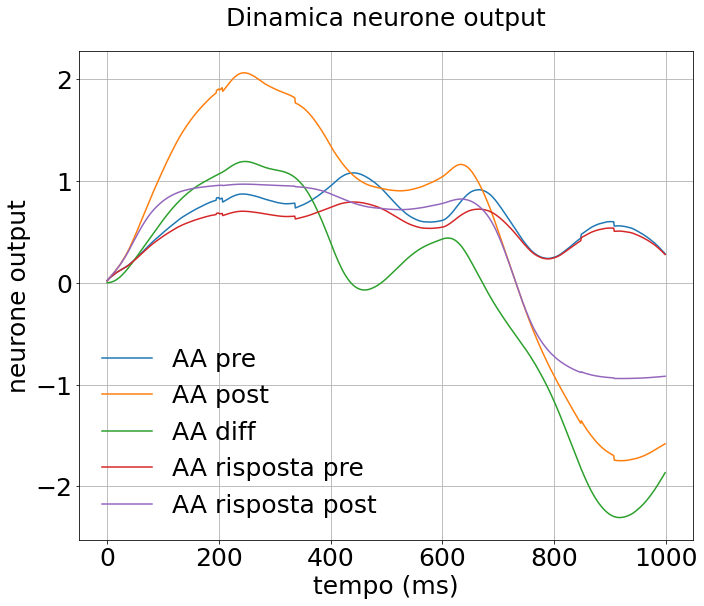

In [ ]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(11,9))
plt.title('Dinamica neurone output', fontsize = 25, pad=25)
plt.xlabel('tempo (ms)')
plt.ylabel('neurone output')

plt.plot(XX_AA[199,:], label='AA pre')
plt.plot(XX_AA_f[199,:], label='AA post')
plt.plot(XX_AA_f[199,:]-XX_AA[199,:], label='AA diff')
#plt.plot(XX_AB[199,:], label='AB pre')
#plt.plot(XX_AB_f[199,:], label='AB post')
#plt.plot(XX_BA[199,:], label='BA pre')
#plt.plot(XX_BA_f[199,:], label='BA post')
#plt.plot(XX_BB[199,:], label='BB pre')
#plt.plot(XX_BB_f[199,:], label='BB post')

RR_AA=np.tanh(XX_AA)
RR_AA_f=np.tanh(XX_AA_f)
plt.plot(RR_AA[199,:], label='AA risposta pre')
plt.plot(RR_AA_f[199,:], label='AA risposta post')


plt.legend(loc=3, frameon=False)
plt.grid()


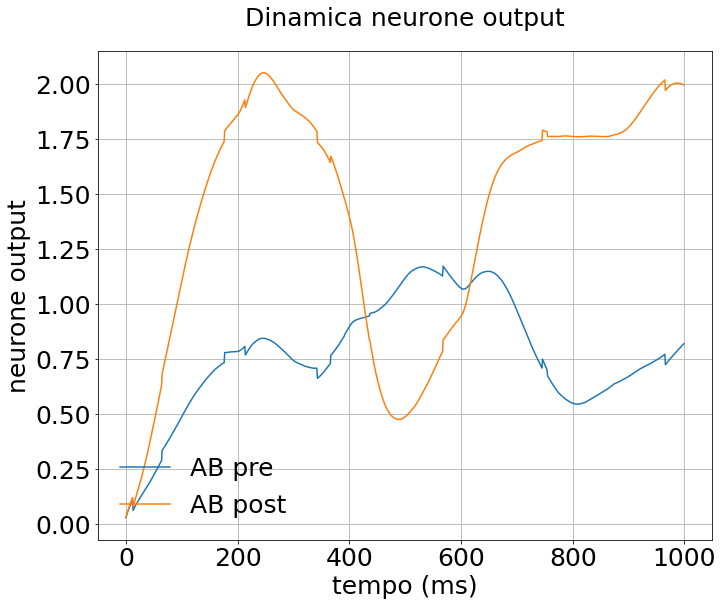

In [ ]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(11,9))
plt.title('Dinamica neurone output', fontsize = 25, pad=25)
plt.xlabel('tempo (ms)')
plt.ylabel('neurone output')

plt.plot(XX_AB[199,:], label='AB pre')
plt.plot(XX_AB_f[199,:], label='AB post')
#plt.plot(XX_BA[199,:], label='BA pre')
#plt.plot(XX_BA_f[199,:], label='BA post')
#plt.plot(XX_BB[199,:], label='BB pre')
#plt.plot(XX_BB_f[199,:], label='BB post')

plt.legend(loc=3, frameon=False)
plt.grid()

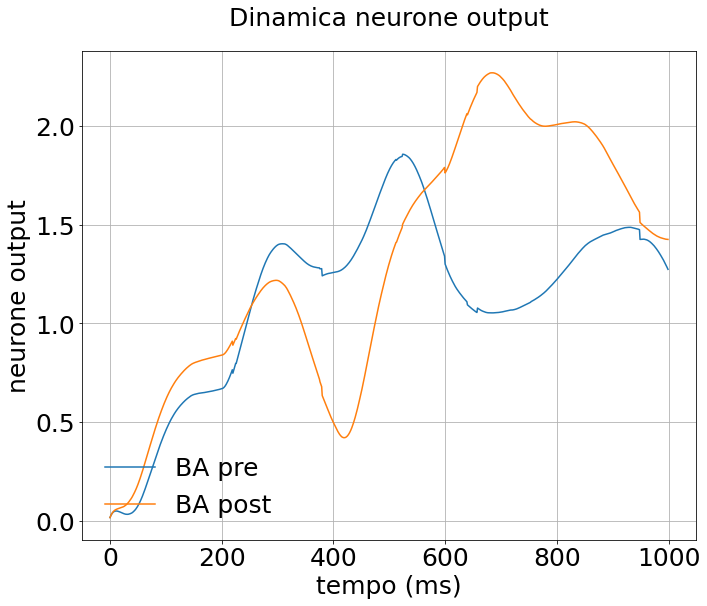

In [ ]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(11,9))
plt.title('Dinamica neurone output', fontsize = 25, pad=25)
plt.xlabel('tempo (ms)')
plt.ylabel('neurone output')

plt.plot(XX_BA[199,:], label='BA pre')
plt.plot(XX_BA_f[199,:], label='BA post')
#plt.plot(XX_BB[199,:], label='BB pre')
#plt.plot(XX_BB_f[199,:], label='BB post')

plt.legend(loc=3, frameon=False)
plt.grid()

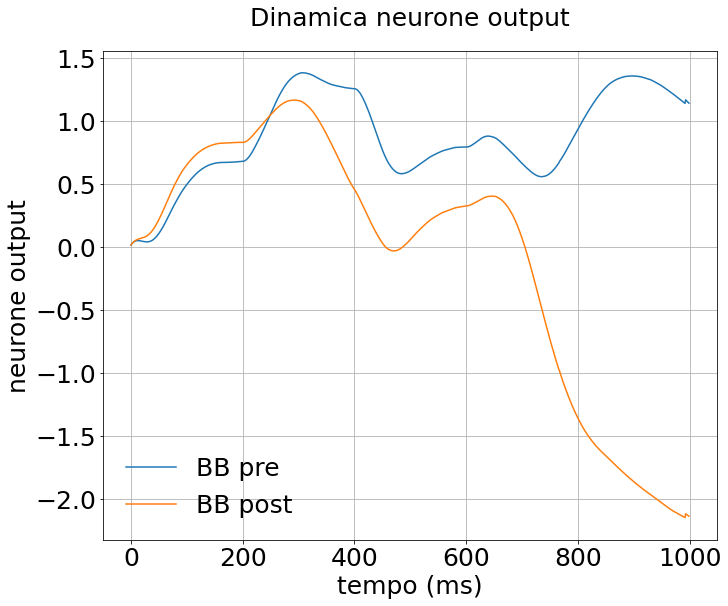

In [ ]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(11,9))
plt.title('Dinamica neurone output', fontsize = 25, pad=25)
plt.xlabel('tempo (ms)')
plt.ylabel('neurone output')

plt.plot(XX_BB[199,:], label='BB pre')
plt.plot(XX_BB_f[199,:], label='BB post')

plt.legend(loc=3, frameon=False)
plt.grid()

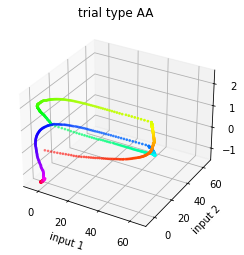

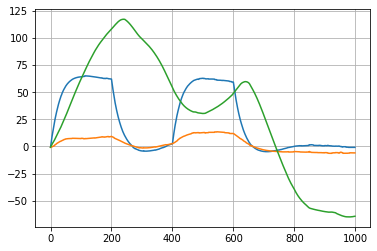

In [ ]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection ="3d")


ax.scatter3D(np.matmul(B[:,0],XX_f[:,:1000]),np.matmul(B[:,1],XX_f[:,:1000]),XX_f[-1,:1000],s=3,c=np.arange(1000),cmap='hsv')
ax.set_xlim(-10,70)
ax.set_ylim(-10,70)
ax.set_xlabel('input 1')
ax.set_ylabel('input 2')
ax.set_zlabel('output')
ax.set_title('trial type AA')



plt.figure()
plt.plot(np.matmul(B[:,0],XX_f[:,:1000]))
plt.plot(np.matmul(B[:,1],XX_f[:,:1000]))
plt.plot(XX_f[-1,:1000]*50)
plt.grid()


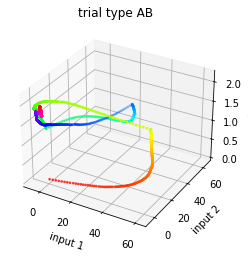

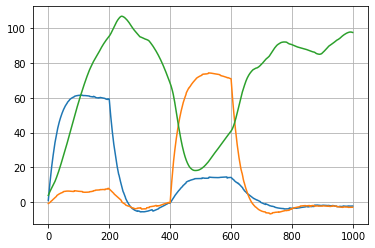

In [ ]:
ax = plt.axes(projection ="3d")


ax.scatter3D(np.matmul(B[:,0],XX_f[:,1000:2000]),np.matmul(B[:,1],XX_f[:,1000:2000]),XX_f[-1,1000:2000],s=3,c=np.arange(1000),cmap='hsv')
ax.set_ylim(-10,70)
ax.set_xlabel('input 1')
ax.set_ylabel('input 2')
ax.set_zlabel('output')
ax.set_title('trial type AB')


plt.figure()
plt.plot(np.matmul(B[:,0],XX_f[:,1000:2000]))
plt.plot(np.matmul(B[:,1],XX_f[:,1000:2000]))
plt.plot(XX_f[-1,1000:2000]*50)
plt.grid()


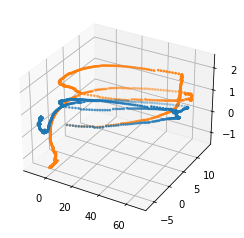

In [ ]:
ax = plt.axes(projection ="3d")

ax.scatter3D(np.matmul(B[:,0],XX[:,0:1000]),np.matmul(B[:,1],XX[:,0:1000]),XX[-1,0:1000],s=3)
ax.scatter3D(np.matmul(B[:,0],XX_f[:,0:1000]),np.matmul(B[:,1],XX_f[:,0:1000]),XX_f[-1,0:1000],s=3)


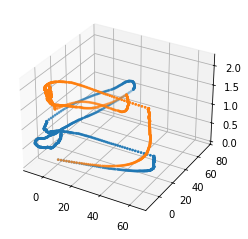

In [ ]:
ax = plt.axes(projection ="3d")

ax.scatter3D(np.matmul(B[:,0],XX[:,1000:2000]),np.matmul(B[:,1],XX[:,1000:2000]),XX[-1,1000:2000],s=3)
ax.scatter3D(np.matmul(B[:,0],XX_f[:,1000:2000]),np.matmul(B[:,1],XX_f[:,1000:2000]),XX_f[-1,1000:2000],s=3)


In [ ]:
from sklearn.decomposition import PCA

ModuleNotFoundError: No module named 'sklearn'

(4000, 3)


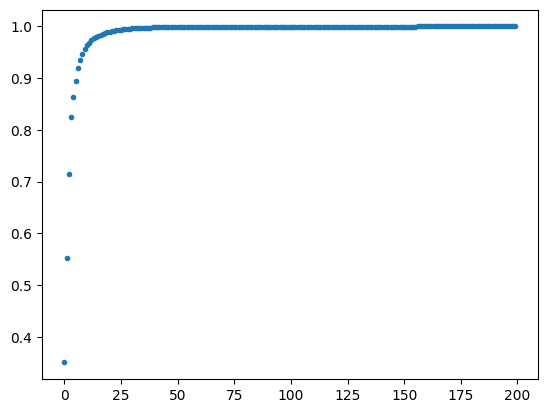

In [ ]:
m = PCA(n_components=200)

m.fit(XX.T)

plt.plot(np.cumsum(m.explained_variance_ratio_),'.')

m = PCA(n_components=3)

XX_pc=m.fit_transform(XX.T)

print(np.shape(XX_pc))

XX_fpc = m.transform(XX_f.T)

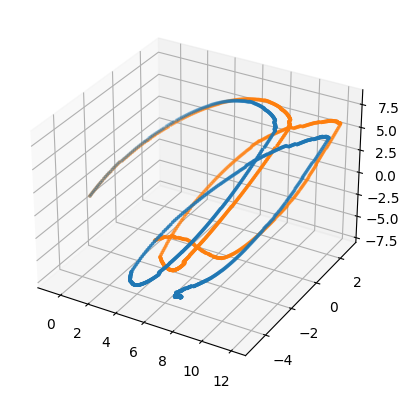

In [ ]:
ax = plt.axes(projection ="3d")

ax.scatter3D(XX_pc[0:1000,0],XX_pc[0:1000,1],XX_pc[0:1000,2],s=3)
ax.scatter3D(XX_fpc[0:1000,0],XX_fpc[0:1000,1],XX_fpc[0:1000,2],s=3)


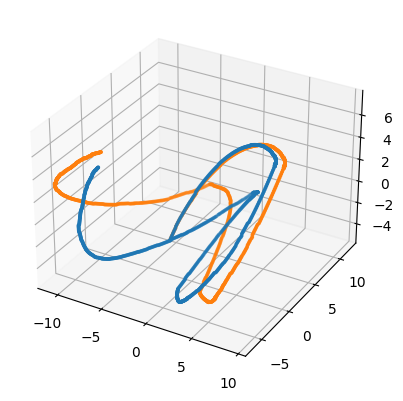

In [ ]:
ax = plt.axes(projection ="3d")

ax.scatter3D(XX_pc[1000:2000,0],XX_pc[1000:2000,1],XX_pc[1000:2000,2],s=3)
ax.scatter3D(XX_fpc[1000:2000,0],XX_fpc[1000:2000,1],XX_fpc[1000:2000,2],s=3)


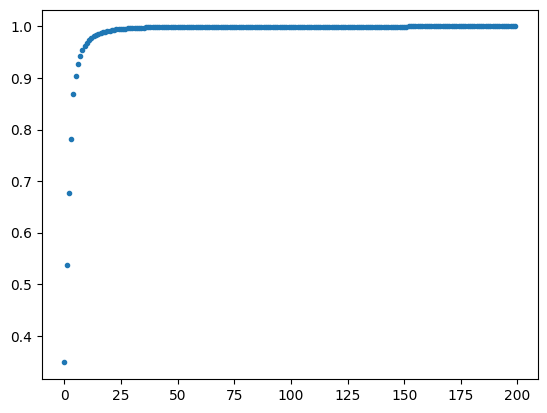

In [ ]:
m = PCA(n_components=200)

m.fit(XX_f.T)

plt.plot(np.cumsum(m.explained_variance_ratio_),'.')